In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# First, we check how many images we have

### Test images

In [2]:
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/benign')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/malignant')))

360
300


### Train images

In [3]:
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/benign')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/malignant')))

1440
1197


# Now, we shall define our model

In [13]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

### Summary of the model layers

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

# I've decided to use generators and "flow_from directory" based on the dataset structure and its amount of pictures

### Use the simple normalization technique where we just divide each pixel value by 255

In [15]:
TRAINING_DIR = "../input/skin-cancer-malignant-vs-benign/train"
bsize=20
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=bsize,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "../input/skin-cancer-malignant-vs-benign/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=bsize,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# I've created a personalized callback based on previous attempts, so I can save the best result I've achieved before.

In [16]:
filepath = 'model.json'
ACCURACY_THRESHOLD = 0.88
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
            print('saving model...')
            model_json = model.to_json()
            with open("model.json", "w") as json_file:
                json_file.write(model_json)
            # serialize weights to HDF5
            model.save_weights("model.h5")
            print("Saved model to disk")

callback = MyCallback()

# Now, we can train the model

In [17]:
num_epochs = 30
history = model.fit(train_generator,
                    epochs=num_epochs,
                    steps_per_epoch=90,
                    validation_data=validation_generator,
                    validation_steps=6,
                    callbacks=[callback] )

Epoch 1/30
90/90 [==============================] - 10s 110ms/step - loss: 0.9646 - acc: 0.6039 - val_loss: 0.6633 - val_acc: 0.6000
Epoch 2/30
90/90 [==============================] - 10s 106ms/step - loss: 0.5964 - acc: 0.6878 - val_loss: 0.4759 - val_acc: 0.7250
Epoch 3/30
90/90 [==============================] - 9s 101ms/step - loss: 0.5572 - acc: 0.7472 - val_loss: 0.4650 - val_acc: 0.7750
Epoch 4/30
90/90 [==============================] - 9s 103ms/step - loss: 0.5105 - acc: 0.7679 - val_loss: 0.4262 - val_acc: 0.7833
Epoch 5/30
90/90 [==============================] - 9s 105ms/step - loss: 0.4728 - acc: 0.7863 - val_loss: 0.4127 - val_acc: 0.8417
Epoch 6/30
90/90 [==============================] - 10s 112ms/step - loss: 0.4540 - acc: 0.7989 - val_loss: 0.3668 - val_acc: 0.8583
Epoch 7/30
90/90 [==============================] - 9s 105ms/step - loss: 0.4362 - acc: 0.8086 - val_loss: 0.4221 - val_acc: 0.7750
Epoch 8/30
90/90 [==============================] - 10s 108ms/step - loss

# As we can see, the best result achieved was 91% of accuracy.

# Let's see the plot

<Figure size 432x288 with 0 Axes>

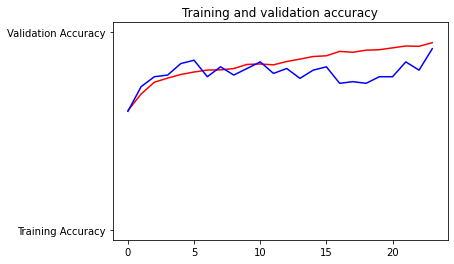

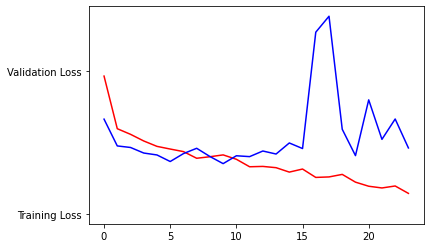

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

## As we can see, the model has proved to be efficient, but the plot shows that it could get even better with more epochs.

# To do:
* Train without the callback or with a bigger accuracy value
* Play with the model and see if I can find more improvements
* Try with different image shape
* Look for different ways to manipulate images, in order to achieve a better result

# You can find my trained model and a way to test it in Google Colab by adding ney images at my github account. 

# https://github.com/exequielmoneva/skin-cancer-detection